## Libraries

In [18]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tube import tube

## Auxiliary Functions

In [114]:
def static_curve(x,Q,dist):    
    if Q == 0:
        y = x / (1-np.exp(-dist*x))
        for i in range(len(x)):                        
            if x[i] == Q:			                     
                y[i] = 1/dist			                     
    else:
        y = (x-Q) / (1-np.exp(-dist*(x-Q))) + Q / (1-np.exp(dist*Q))
        for i in range(len(x)):				        
            if x[i] == Q:					            
                y[i] = 1 / dist + Q / (1-np.exp(dist*Q))
    return y

def waterfspec(signal, steps, start=0, N=1024, fs=48000, clippingpoint=0, baseplane=-100, size=(10,10)):
    # Signal processing section
    window = np.blackman(N)
    window = window * N / sum(window)
    n = len(signal)
    rest = n - start - N
    nos = int(np.round(rest / steps))
    speks = np.zeros((nos, N + 1))
    if nos > rest / steps:
         nos = nos - 1
    x = np.linspace(0, fs / 1000, N + 1)
    z = np.zeros_like(x)
    cup = z + clippingpoint
    cdown = z + baseplane
    signal = signal + 0.0000001
    z_values = np.zeros((len(x), nos))
    y = np.linspace(0, nos, nos)
    for i in range(nos):
        spek1 = 20 * np.log10(np.abs(np.fft.fft(window * signal[start + i * steps : start + N + i * steps])) / N / 0.5)
        spek = np.concatenate(([-200], spek1[0 : N])).T
        spek = (spek > cup.T) * cup.T + (spek <= cup.T) * spek
        spek = (spek < cdown.T) * cdown.T + (spek >= cdown.T) * spek
        spek[0] = baseplane - 10
        spek[N//2 - 1] = baseplane - 10
        z_values[:, i] = spek
        speks[i, :] = spek

    # Graphics section    

    spec_len = N // 2

    fig = plt.figure(figsize=size)

    ax = fig.add_subplot(111, projection='3d')
    x = list(range(spec_len))
    for i in range(nos):
        y = [i] * spec_len
        z = speks[i, 0 : spec_len].tolist()
        vertices = [list(zip(x, y, z))]

        poly = Poly3DCollection(vertices, facecolors='w', linewidths=1, alpha=0.8)
        poly.set_edgecolor('k')
        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1.5, 0.5, 1]))
        ax.add_collection3d(poly)

    ax.add_collection3d(poly)

    ax.set_xlim(0, spec_len)

    ax.set_ylim(0, nos)

    ax.set_zlim(np.min(speks), np.max(speks))

    ax.xaxis.set_major_locator(plt.MaxNLocator(5))

    xticks_list = [str(round(f, 1)) for f in np.linspace(0, fs / 2000, 5)]
    ax.set_xticklabels(xticks_list)

    ax.yaxis.set_major_locator(plt.MaxNLocator(8))

    yticks_list = [n for n in np.arange(0, len(signal), 1000)]
    ax.set_yticklabels(yticks_list)

    ax.set_xlabel(r'f in kHz $\to$')

    ax.set_ylabel(r'n $\longrightarrow$ ')

    ax.set_zlabel(r'Magnitude in dB $\to$')

## Tests

In [137]:
N = 10000
fs = 48000
x = np.cos(2*np.pi*1000*np.arange(N)/fs)

gain = 1
Q = -0.2
dist = 8
rh = 0.99
rl = 0
mix = 1

c = static_curve(np.linspace(-1,1,N),Q,dist)

y = tube(x, gain, Q, dist, rh, rl, mix)

## Plots

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


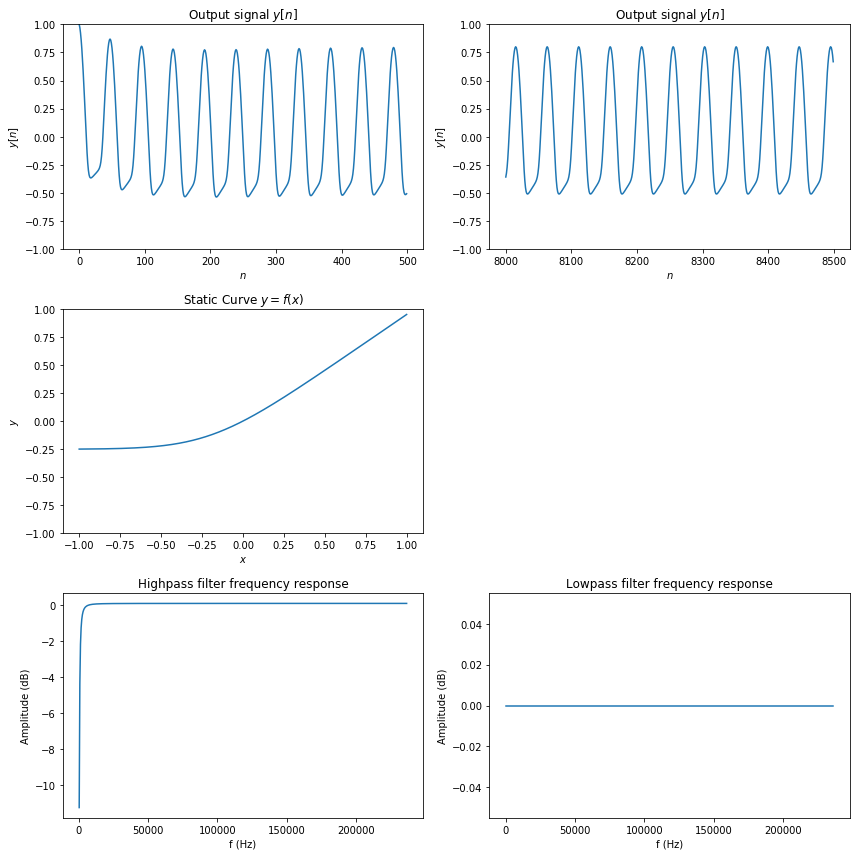

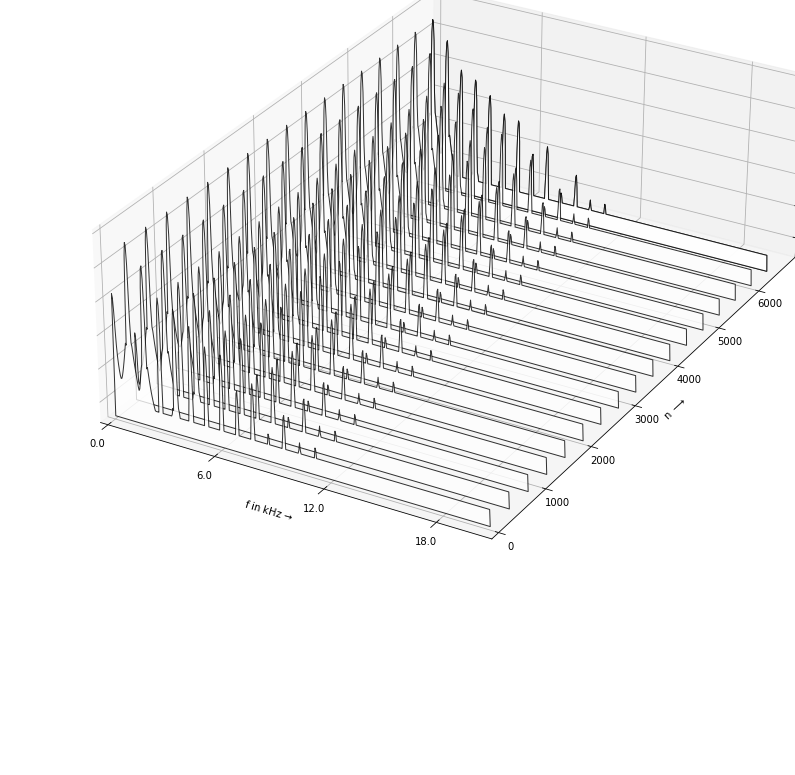

In [138]:
plt.figure(figsize=(12, 12))

plt.subplot(321)
plt.plot(range(N)[0:500], y[0:500])
plt.axis(ymin = -1, ymax = 1)
plt.ylabel('$y[n]$')
plt.xlabel('$n$')
plt.title('Output signal $y[n]$')
plt.tight_layout()

plt.subplot(322)
plt.plot(range(N)[8000:8500], y[8000:8500])
plt.axis(ymin = -1, ymax = 1)
plt.ylabel('$y[n]$')
plt.xlabel('$n$')
plt.title('Output signal $y[n]$')
plt.tight_layout()

plt.subplot(323)
plt.plot(np.linspace(-1,1,N), c)
plt.axis(ymin = -1, ymax = 1)
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.title('Static Curve $y=f(x)$')
plt.tight_layout()

w, h = signal.freqz([1, -2, 1],[1, -2*rh, rh**2])
plt.subplot(325)
plt.plot(w*(fs/2*np.pi), 20 * np.log10(abs(h)))
plt.ylabel('Amplitude (dB)')
plt.xlabel('f (Hz)')
plt.title('Highpass filter frequency response')
plt.tight_layout()

w, h = signal.freqz([1-rl],[1, -rl])
plt.subplot(326)
plt.plot(w*(fs/2*np.pi), 20 * np.log10(abs(h)))
plt.ylabel('Amplitude (dB)')
plt.xlabel('f (Hz)')
plt.title('Lowpass filter frequency response')
plt.tight_layout()

waterfspec(y, 512, 0, 1024, fs, clippingpoint=0, baseplane=-100, size=(14,14))